# U-Net On Vaihingen Dataset

In this lab session, you will use a U-Net model to perform semantic segmentation on the Vaihingen Dataset.
The full Vaihingen dataset is available for download [here](https://www.kaggle.com/datasets/naydex/vaihingen-cropped), but in this lab you will use a smaller version (see details below) to have affordable training times.

As a reminder, the U-Net architecture is defined as follows :

[<img src="https://camo.githubusercontent.com/41ded1456b9dbe13b8d73d8da539dac95cb8aa721ebe5fb798af732ca9f04c92/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67" alt="drawing" width="1000">](https://github.com/milesial/Pytorch-UNet)

This notebook is derived from a nice U-Net implementation in PyTorch (click the image to access it). For more information, you can take a look at the [paper](https://arxiv.org/pdf/1505.04597.pdf)!

In [1]:
import os
import numpy as np
import keras_core as keras
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, ReLU, Input, ZeroPadding2D
from keras.models import Sequential, Model
import tensorflow as tf

import matplotlib.pyplot as plt

2022-12-15 16:02:57.379326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The UNet Model

You will start by defining the UNet architecture to be used for this session. As a helper, the following blocks are defined:

* `double_conv2d`: each sequence of two consecutive convolutions in the UNet model can be replaced by such a block
* `down_sampling_block`: each sequence of a down-sampling followed by a two convolutions can be replaced by such a block
* `up_sampling_block`: each sequence of an up-sampling (transposed convolution) followed by two convolutions can be replaced by such a block.

In [2]:
def double_conv2d(output_channels):
    return Sequential([
        Conv2D(filters=output_channels, kernel_size=3, padding="same"),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=output_channels, kernel_size=3, padding="same"),
        BatchNormalization(),
        ReLU()
    ])

def down_sampling_block(output_channels):
    return Sequential([
        MaxPool2D(pool_size=2),
        double_conv2d(output_channels)
    ])

def up_sampling_block(output_channels, shape1, shape2):
    x1 = Input(shape=shape1)
    x2 = Input(shape=shape2)
    x1_up = Conv2DTranspose(output_channels, kernel_size=2, strides=2)(x1)
    
    # input is HWC
    diffY = x2.get_shape().as_list()[1] - x1_up.get_shape().as_list()[1]
    diffX = x2.get_shape().as_list()[2] - x1_up.get_shape().as_list()[2]

    x1_up = ZeroPadding2D(padding=((diffY // 2, diffY - diffY // 2), (diffX // 2, diffX - diffX // 2)))(x1_up)
    x = tf.concat([x2, x1_up], axis=-1)
    return Model(inputs=[x1, x2], outputs=double_conv2d(output_channels)(x))

**Question 1.** Using the Keras Functional API, define the UNet architecture shown above.

In [3]:
def unet_model(image_size, n_classes):
    inputs = Input(shape=image_size + (3,))
    x0 = double_conv2d(64)(inputs)
    
    x1 = down_sampling_block(128)(x0)
    x2 = down_sampling_block(256)(x1)
    x3 = down_sampling_block(512)(x2)
    x4 = down_sampling_block(1024)(x3)
    
    x = up_sampling_block(512, shape1=x4.shape[1:], shape2=x3.shape[1:])((x4, x3))
    x = up_sampling_block(256, shape1=x.shape[1:], shape2=x2.shape[1:])((x, x2))
    x = up_sampling_block(128, shape1=x.shape[1:], shape2=x1.shape[1:])((x, x1))
    x = up_sampling_block(64, shape1=x.shape[1:], shape2=x0.shape[1:])((x, x0))
    
    outputs = Conv2D(filters=n_classes, kernel_size=1, activation="softmax")(x)
    
    return Model(inputs, outputs)

## The data

You will now download the mini-Vaihingen dataset from CURSUS and put the zip file in your working folder.
The following command should unzip it:

In [4]:
!unzip -o mini-vaihingen.zip

Archive:  mini-vaihingen.zip
  inflating: vaihingen-cropped-small/vaihingen_train/.DS_Store  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_0_1_gt.npy  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_1_gt.npy  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_0_3_gt.npy  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_3_gt.npy  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_4.png  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_0.png  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_4_gt.npy  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_0_4_gt.npy  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_1.png  
  inflating: vaihingen-cropped-small/vaihingen_train/top_mosaic_09cm_area1_1_3.png  
  inflating: vaihingen-cropped-small/v

Now the following code defines a loader for the training data and another one for the validation data:

In [5]:
from PIL import Image
import os

class VaihingenDataset(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, folder, small_subset=False):
        self.batch_size = batch_size
        self.input_img_paths = sorted([
            os.path.join(folder, fname)
            for fname in os.listdir(folder)
            if fname.endswith(".png")
        ])
        if small_subset:
            self.input_img_paths = self.input_img_paths[:2 * batch_size]
        self.normalization_means = np.array([0.4643, 0.3185, 0.3141])
        self.normalization_stds = np.array([0.2171, 0.1561, 0.1496])

    def __len__(self):
        return max(1, len(self.input_img_paths) // self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = []
        y = []
        for j, path in enumerate(batch_input_img_paths):
            img = Image.open(path).convert("RGB")
            x.append(np.asarray(img) / 255.)
            y.append(np.load(path.replace(".png", "_gt.npy")))
        x = np.array(x)
        y = np.array(y)
        x -= self.normalization_means[None, None, None, :]
        x /= self.normalization_stds[None, None, None, :]
        return x, y

train_loader = VaihingenDataset(batch_size=10, folder="vaihingen-cropped-small/vaihingen_train/")
val_loader = VaihingenDataset(batch_size=10, folder="vaihingen-cropped-small/vaihingen_test/")

**Question 2.** Inspect the first batch (`train_loader[0]`) from the training set. What are the shapes of `X` and `y`? And what values can they take?

In [6]:
X, y = train_loader[0]
print(X.shape, y.shape)
print(y[0, 0, 0])
print(np.unique(y))

(9, 512, 512, 3) (9, 512, 512)
1
[0 1 2 3 4 5]


**Question 3.** Define, compile and fit (for one or two epochs, no more) a UNet model using the `unet_model` function defined above.
What accuracy can you reach on the validation set?

In [9]:
model = unet_model((512, 512), 6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.fit(train_loader, epochs=2, validation_data=val_loader)

**Question 4.** Download the pre-trained model from CURSUS and put it in your working folder.
Load its weights using `model.load_weights("pretrained_unet.h5")` and evaluate its performance on the validation set using [`model.evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate).

In [11]:
model.load_weights("pretrained_unet.h5")
model.evaluate(val_loader)

1/1 [==============================] - 40s 40s/step - loss: 0.6267 - accuracy: 0.8121


[0.6267334818840027, 0.8120719790458679]

## Let's see the results !

**Question 5.** Use the code below to visualize the obtained results on some of the validation samples.

In [12]:
# The color palette to colorize pixels depending on their assigned class.

palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

In [13]:
# Take a validation batch !

images, labels = next(iter(val_loader))

pred_labels = model(images).numpy().argmax(axis=-1)

In [14]:
# A bit technical.

color_preds = np.zeros((*pred_labels.shape, 3), dtype=np.float32)
gt_color_preds = np.zeros((*pred_labels.shape, 3), dtype=np.float32)

for cls, col in palette.items():
    for i in range(pred_labels.shape[0]):
        color_preds[i, pred_labels[i, :] == cls,:] = col
        gt_color_preds[i, labels[i, :] == cls,:] = col

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

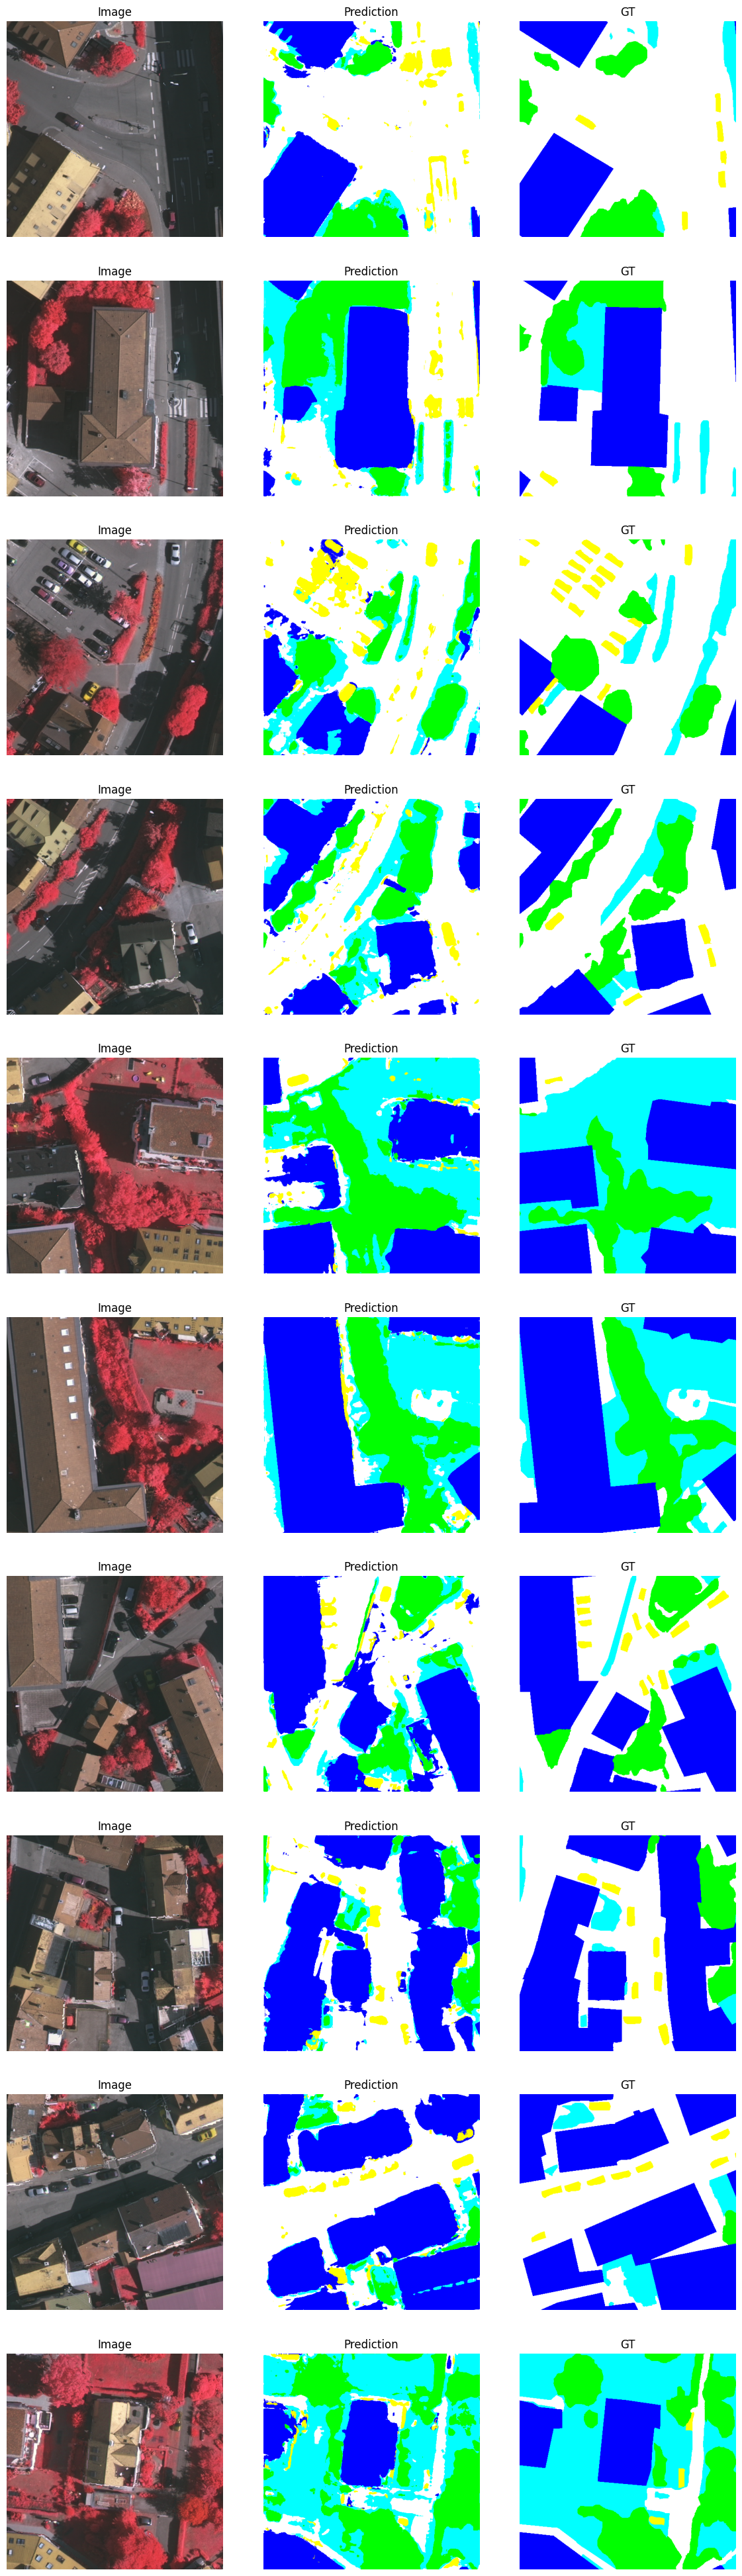

In [15]:
# And now let's see it !

def denormalize_image(image, mean, std):
    """Denormalize the image."""
    return image * std[None, None, :] + mean[None, None, :]

fig, axes = plt.subplots(len(images), 3, figsize=(15, 5 * len(images)))
fig.subplots_adjust(wspace=0)

for i, (image, color_pred, gt_color_pred) in enumerate(zip(images, color_preds, gt_color_preds)):
    axes[i][0].imshow(denormalize_image(image, val_loader.normalization_means, val_loader.normalization_stds))
    axes[i][0].axis('off')
    axes[i][0].set_title("Image")
    axes[i][1].imshow(color_pred)
    axes[i][1].axis('off')
    axes[i][1].set_title("Prediction")
    axes[i][2].imshow(gt_color_pred)
    axes[i][2].axis('off')
    axes[i][2].set_title("GT")

plt.axis('off')
plt.show()